
# TCCM school - Multiscale, Machine Learning and QSAR methods applied to biomolecules

## Introduction to Deep Learning, Tensorflow/Keras and Convolutional neural network

### Sergio Orlandini - s.orlandini@cineca.it

*21-09-2022*

https://github.com/so07/TCCM-DL-2022

```
git clone https://github.com/so07/TCCM-DL-2022.git
```

# Introduction to Keras

* <a href="https://keras.io">Keras</a> is a high-level neural networks API, written in **Python**, developed with a focus on enabling fast experimentation.
* Keras is the **TensorFlow**’s high-level API for building and training deep learning models
* Kesas is one of the most used Deep Learning Framework used by researchers, and is now part of the https://www.tensorflow.org/guide/keras official TensorFlow Higher Level API as `tensorflow.keras`
* Keras offers a consistent and simple API, which minimizes the number of user actions required for common use cases, and provides clear and actionable feedback upon user error.
* Keras is capable of running on top of many deep learning backends such as TensorFlow, CNTK, or Theano. This capability allows Keras model to be portable across all there backends.
* Keras models can be trained on CPUs, Xeon Phi, Google TPUs and any GPU or OpenCL-enabled GPU like device.

<img src="figures/DL_framework_usage.png" width="75%">

# How to install TensorFlow/Keras

- [How to install with pip](https://www.tensorflow.org/install/pip)
- [How to install with conda](https://docs.anaconda.com/anaconda/user-guide/tasks/tensorflow/)

## Neural Networks for Regression

Define a set of input data which deviate from a generated function for a random noise.
We will train a neural network to predict data behaviour.


In [1]:
import numpy as np
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from math import sin, pi

# generate training inputs
x = np.linspace(-5, 5, 500)

# ideal (target) generated function
y_target = np.array([sin(i) + 2.6 for i in x])
#y_target = np.array([abs(i) for i in x]) * 0.5 + 2

# noise amplitude
noise_amp = 1.0

# actual measures from which we want to guess regression parameters
y_train = y_target + noise_amp * (np.random.rand(len(x))-0.5)

print("Number of points =", len(y_target))

Number of points = 500


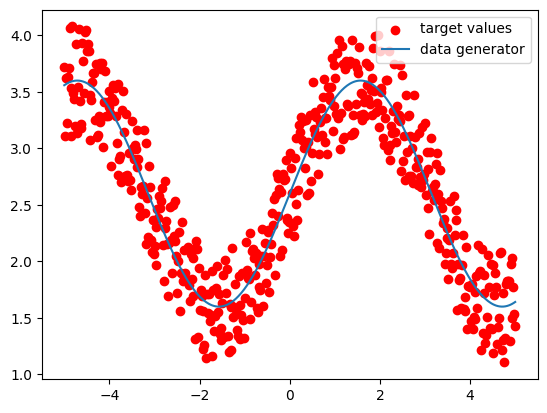

In [3]:
# plot training and target dataset
plt.scatter(x, y_train, color="r", label="target values")
plt.plot(x, y_target, label="data generator");
plt.legend()
plt.show()

## Build a Model with Keras

The core data structure of Keras is the [**Model**](https://keras.io/models/about-keras-models/)
which is basically a container of one or more [**Layers**](https://keras.io/layers/core/). \
There are two main types of models available in Keras: the **Sequential** and the **Model** class,
the latter is used to create advanced models. \
The simplest type of model is the Sequential model, which is a linear stack of layers.
Each layer is added to the model using the `add()` method of the Sequential model object. \
The model needs to know what input shape it should expect.
The first layer in a Sequential model (and only the first) needs to receive information about its input shape, specifing the `input_shape` argument. \
The following layers can do automatic shape inference from the shape of its predecessor layer.

<img src="figures/dense.png" width="300pt">


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_nodes = 3

model = Sequential()

# adds to the model a densely-connected layer with num_nodes units
model.add(Dense(num_nodes, input_shape=(1,), activation="tanh"))

#model.add(Dense(10, activation="tanh"))

# last layer with only 1 unit connected to outputs of previous layer
model.add(Dense(1, use_bias=False))


The **activation** argument specifies the activation function for the current layer.
By default, no activation is applied. \
Keras provides many types of layers and activation functions implementations,
which we are going to explore later in this course.

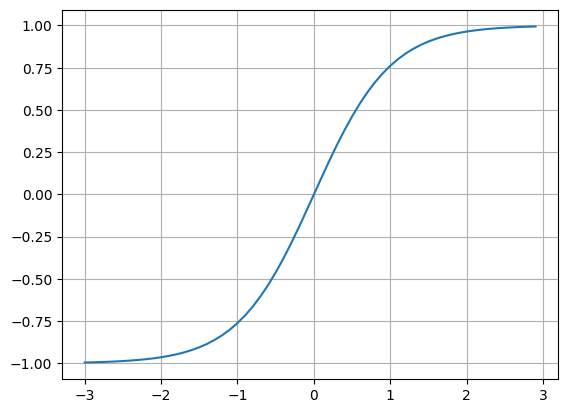

In [5]:
from tensorflow.keras import activations

x_values = np.arange(-3, 3, 0.1)
tanh = activations.tanh(x_values)

plt.plot(x_values, tanh, label="tanh")
plt.grid();

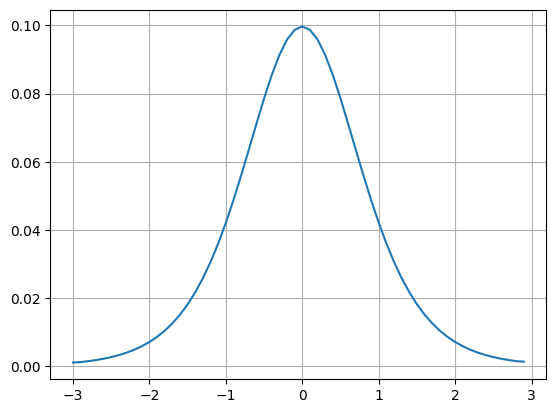

In [6]:
plt.plot(x_values, np.gradient(tanh), label="tanh derivatives")
plt.grid();

## Compile the model

After the model is defined, its learning process has to be configured by calling the `compile` method. \
The compile phase is required to configure the following elements of the model:
- [**optimizer**](https://keras.io/optimizers/): this object specifies the optimization algorithm which adapt the weights of the layers during the training procedure;
- [**loss**](https://keras.io/losses/): this object specifies the function to minimize during the optimization;
- [**metrics**](https://keras.io/metrics/): this object judges the performance of your model and is used to monitor the training

In [7]:
# compile the model choosing optimizer, loss and metrics object

model.compile(optimizer="adam", loss="mse") # metrics=["mse"]) # metrics is optional here

In [8]:
from tensorflow.keras.optimizers import Adam

# compile the model choosing optimizer, loss and metrics object
optimizer = Adam(learning_rate=0.1)

model.compile(optimizer=optimizer, loss="mse") # metrics=["mse"]) # metrics is optional here

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 6         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


## Train the model

We are now going to train our model, that is we feed the neurons with the set of training pair `x`, `y_train` from which the optimizer will find the best weights to minimize the Mean Square Error loss function.

The `fit` method can also get [`callbacks`](https://keras.io/callbacks/) functions which can be used to customize the fitting procedure with special actions.

Keras provides some predefined callbacks to feed in, among them for example:
- `EarlyStopping`: which stop training when a monitored quantity has stopped improving
- `ModelCheckpoint`: that save the model after every epoch
- `TerminateOnNaN`: that terminates training when a NaN loss is encountered
- `ProgbarLogger`: that prints metrics to stdout
- `LambdaCallback`:  for creating simple, custom callbacks on-the-fly

You can select one or more callback and pass them as a list to the callback argument of the fit method.

In [10]:
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(
    # quantity to be monitored: stop training when `val_loss` is no longer improving
    monitor="val_loss",
    # minimum change in the monitored quantity: a change less than min_delta will count as no improvement
    min_delta=0.001,
    # number of epochs with no improvement after which training will be stopped
    patience=50)


You can also create a callback object from scratch,
customizing its behaviour overloading the base methods of the Callback Keras class:
- `on_train_begin` and `on_train_end`
- `on_epoch_begin` and `on_epoch_end`
- `on_batch_begin` and `on_batch_end`

A callback has access to its associated model through the class attribute `self.model`,
so that you can monitor and access many of the quantities which are in the optimization process.

In [11]:
from tensorflow.keras import backend

class PlotCurrentEstimate(callbacks.Callback):
    """Callback to plot loss value and layers while training"""
    
    def __init__(self, update_freq=2):
        self.epoch = 0
        self.update_freq = update_freq
        
    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
       
        if self.epoch % self.update_freq == 0:
            h = self.model.history.history
            
            y_curr = self.model.predict(x)
            clear_output(wait=True)
            
            plt.figure(figsize=(15, 10))
            
            plt.subplot(221)
            # plot hline
            plt.axhline(1.0, color="gray", alpha=0.25, lw=0.9)
            plt.axhline(-1.0, color="gray", alpha=0.25, lw=0.9)

            plt.ylim(-1.5, 4.5)
            # target values
            plt.scatter(x, y_train, color='r', alpha=0.25, facecolors='none')
            # data-generating function
            plt.plot(x, y_target, color="red", lw=2, label="valid", alpha=0.5)
            # network output
            plt.plot(x, y_curr, color="blue", linestyle="dashed", label="estimate")
            plt.legend(loc='upper right')
            
            # get hidden layer
            layer = backend.function([model.layers[0].input], [model.layers[0].output])
            # hidden tanh output
            z = layer([x.reshape(x.shape[0], 1)])[0]
            
            # plot layer nodes
            for i in range(z.shape[1]):
                plt.plot(x, z[:, i], label=f"Hidden #{i}")
            
            plt.subplot(222)
            
            plt.title("Mean Squared Error")
            plt.plot(h["loss"], label="train")
            plt.plot(h["val_loss"], label="validate")
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.legend(loc="upper right")
            
            plt.show()


class SaveWeightsAndBias(callbacks.Callback):
    """Callback to save weights and bias while training"""

    def on_train_begin(self, logs={}):
        self.weights = []
        self.bias = []

    def on_epoch_end(self, epoch, logs={}):
        # get weights and biases from hidden layer
        weights, bias = model.layers[0].get_weights()
        self.weights.append(weights[0])
        self.bias.append(bias)

    def on_train_end(self, logs={}):
        self.weights = np.array(self.weights).T
        self.bias = np.array(self.bias).T


trainplot = PlotCurrentEstimate()

weight_and_bias = SaveWeightsAndBias()

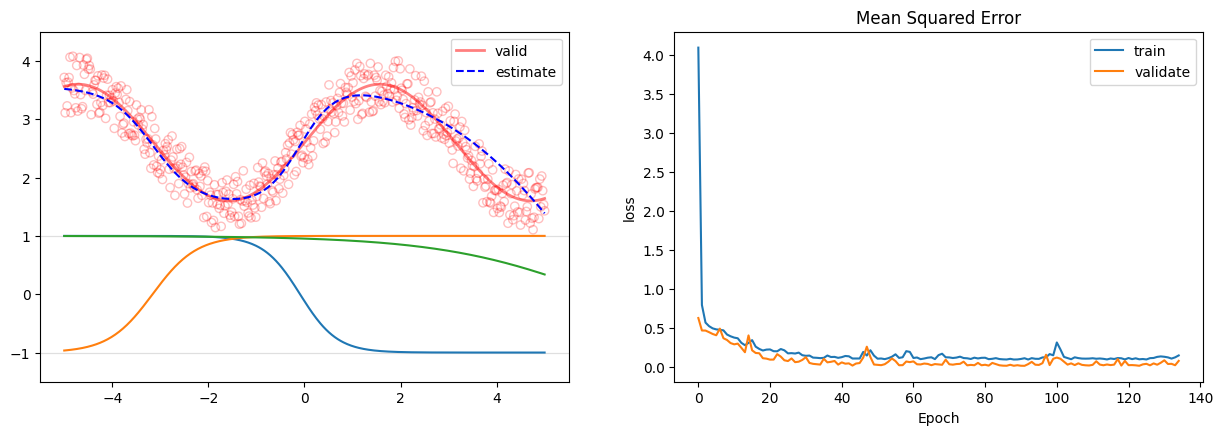

In [12]:
batch_size=32
epochs=200

model.fit(x, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[trainplot, weight_and_bias, earlystop],
          validation_data=(x, y_target), # used to evaluate the loss and any model metrics at each epoch
          verbose=0);


The values of weights and bias of a given layer can be obtained from model instance with `get_weights()` method.

In [13]:
# get weights and biases from hidden layer
weights, bias = model.layers[0].get_weights()

for w, b in zip(weights[0], bias):
    print(w, b)

-1.3099337 -0.14694639
1.1516675 3.4163942
-0.36316326 1.8454937


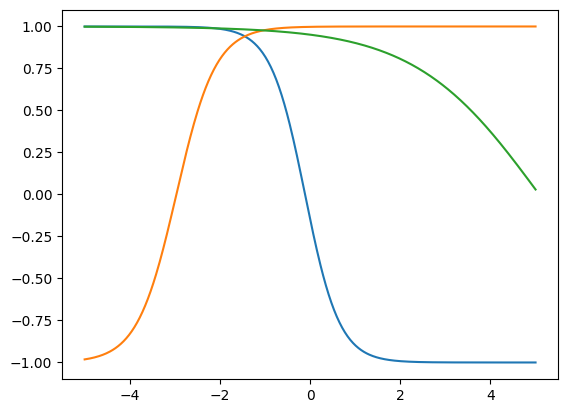

In [14]:
from tensorflow.keras import activations

for w, b in zip(weights[0], bias):
    plt.plot(x, activations.tanh(w*x + b))
plt.show()

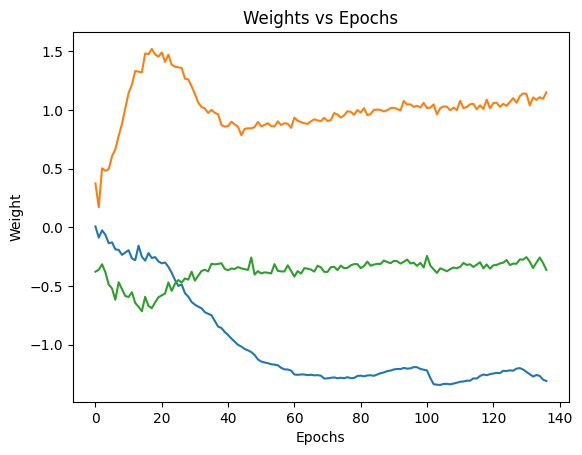

In [15]:
for w in weight_and_bias.weights:
    plt.plot(w)
    
plt.xlabel("Epochs")
plt.ylabel("Weight")
plt.title("Weights vs Epochs");

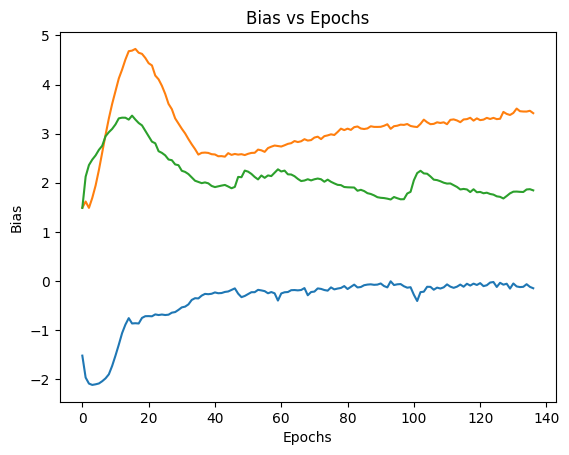

In [16]:
for b in weight_and_bias.bias:
    plt.plot(b)
    
plt.xlabel("Epochs")
plt.ylabel("Bias")
plt.title("Bias vs Epochs");

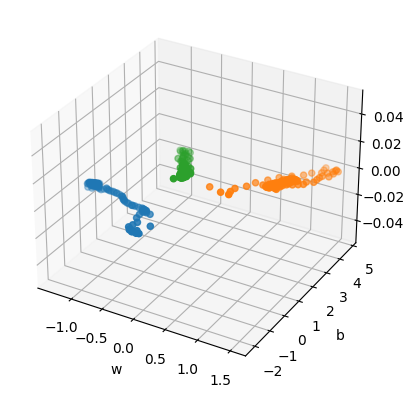

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d') # matplotlib 3.6.0


ws = weight_and_bias.weights
bs = weight_and_bias.bias

ax.scatter(ws[0,:], bs[0,:])
ax.scatter(ws[1,:], bs[1,:])
ax.scatter(ws[2,:], bs[2,:])

plt.xlabel("w")
plt.ylabel("b")

plt.show()